# NDVI Clustering Analysis

This notebook demonstrates K-means clustering on NDVI (Normalized Difference Vegetation Index) data to identify different vegetation patterns or zones.

We'll use scikit-learn's K-means implementation to cluster NDVI values from GeoTIFF files.

In [18]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
from pathlib import Path

# Add current directory to path
sys.path.append('.')

# Import our clustering module
from ndvi_clustering import (load_ndvi_raster, preprocess_for_clustering,
                            apply_kmeans, create_clustered_image, apply_sieve_filter,
                            save_clustered_image, create_cluster_visualization)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load NDVI Data

First, let's load an NDVI GeoTIFF file. You can use the NDVI generated from the monthly_ndvi_calculation module.

In [19]:
# Define the path to the NDVI file
ndvi_file_path = "../monthly_ndvi_calculation/monthly_max_ndvi.tif"

# Check if file exists
if not os.path.exists(ndvi_file_path):
    print(f"Warning: {ndvi_file_path} does not exist. Please run the NDVI calculation first.")
else:
    print(f"NDVI file found: {ndvi_file_path}")

NDVI file found: ../monthly_ndvi_calculation/monthly_max_ndvi.tif


2025-08-22 11:09:35,026 - ndvi_clustering - INFO - Loading NDVI data from ../monthly_ndvi_calculation/monthly_max_ndvi.tif
2025-08-22 11:09:35,070 - ndvi_clustering - INFO - NDVI data loaded with shape (1099, 1098)


NDVI array shape: (1099, 1098)
NDVI value range: -0.9414 to 0.9835
NDVI mean value: -0.5326


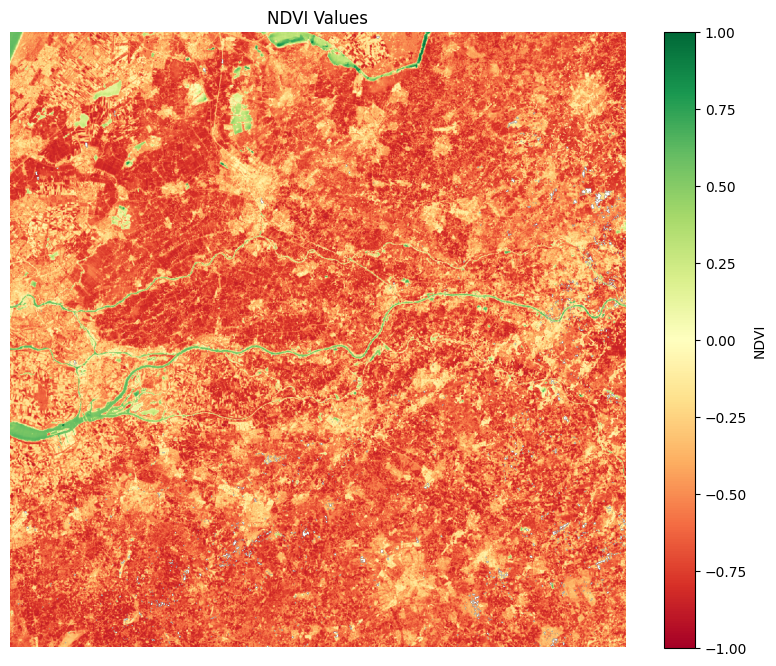

In [20]:
# Load the NDVI data
ndvi_array, profile = load_ndvi_raster(ndvi_file_path)

# Display basic information
print(f"NDVI array shape: {ndvi_array.shape}")
print(f"NDVI value range: {np.nanmin(ndvi_array):.4f} to {np.nanmax(ndvi_array):.4f}")
print(f"NDVI mean value: {np.nanmean(ndvi_array):.4f}")

# Visualize the NDVI raster
plt.figure(figsize=(10, 8))
plt.imshow(ndvi_array, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI Values')
plt.axis('off')
plt.show()

## Preprocess Data for Clustering

Next, we'll preprocess the NDVI data to prepare it for clustering. This involves:
1. Removing invalid values (NaN, values outside [-1, 1])
2. Standardizing the features

In [21]:
# Preprocess the data
features, mask = preprocess_for_clustering(ndvi_array)

# Display preprocessing results
print(f"Original data shape: {ndvi_array.shape}")
print(f"Valid pixels for clustering: {features.shape[0]}")
print(f"Feature shape after preprocessing: {features.shape}")
print(f"Valid pixels percentage: {np.sum(mask) / mask.size * 100:.2f}%")

2025-08-22 11:09:36,382 - ndvi_clustering - INFO - Preprocessing NDVI data for clustering
2025-08-22 11:09:36,425 - ndvi_clustering - INFO - Preprocessed 1199783 valid NDVI points


Original data shape: (1099, 1098)
Valid pixels for clustering: 1199783
Feature shape after preprocessing: (1199783, 1)
Valid pixels percentage: 99.43%


Select the number of cluster as hyperparameter. We can find optimal number of cluster usiong Elbow curve.

In [22]:
# Define the number of clusters to use
n_clusters = 5  # Adjust this based on the Elbow curve
print(f"Using {n_clusters} clusters for K-means clustering")

Using 5 clusters for K-means clustering


## Apply K-means Clustering

In [23]:
# Apply K-means clustering
cluster_labels, cluster_centers = apply_kmeans(features, n_clusters=n_clusters)

# Display cluster information
print(f"Cluster centers (standardized):\n")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}: {center[0]:.4f}")

# Count the number of pixels in each cluster
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_counts = dict(zip(unique, counts))

# Display counts and percentages
print("\nCluster distribution:")
for cluster, count in cluster_counts.items():
    percentage = count / len(cluster_labels) * 100
    print(f"Cluster {cluster}: {count} pixels ({percentage:.2f}%)")

2025-08-22 11:09:39,768 - ndvi_clustering - INFO - Applying K-means clustering with 5 clusters
2025-08-22 11:09:41,143 - ndvi_clustering - INFO - K-means clustering completed


Cluster centers (standardized):

Cluster 0: 0.4762
Cluster 1: -0.9784
Cluster 2: 1.3490
Cluster 3: 3.9288
Cluster 4: -0.2665

Cluster distribution:
Cluster 0: 280408 pixels (23.37%)
Cluster 1: 361553 pixels (30.13%)
Cluster 2: 164454 pixels (13.71%)
Cluster 3: 24732 pixels (2.06%)
Cluster 4: 368636 pixels (30.73%)


## Create Clustered Image

In [24]:
# Create clustered image
clustered_image = create_clustered_image(ndvi_array, mask, cluster_labels, n_clusters)

# Apply sieve filter to remove small isolated clusters
# min_size = 10  # Minimum size of clusters to keep
# filtered_image = apply_sieve_filter(clustered_image, min_size=min_size)

filtered_image = clustered_image  # Skip filtering for now

2025-08-22 11:09:44,401 - ndvi_clustering - INFO - Creating clustered image
2025-08-22 11:09:44,403 - ndvi_clustering - INFO - Clustered image created


## Visualize Clustering Results

In [25]:
def visualize_images(ndvi_array, filtered_image):

    # Create a visualization with both original NDVI and clustered result
    plt.figure(figsize=(16, 8))

    # Plot original NDVI
    plt.subplot(1, 2, 1)
    plt.imshow(ndvi_array, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(label='NDVI')
    plt.title('Original NDVI')
    plt.axis('off')

    # Plot clustered image
    plt.subplot(1, 2, 2)
    masked_clusters = np.ma.masked_where(filtered_image == -9999, filtered_image)
    plt.imshow(masked_clusters, cmap='viridis', vmin=0, vmax=n_clusters-1)
    plt.colorbar(label='Cluster ID')
    plt.title('NDVI Clusters')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Create more detailed visualization
    output_dir = "output"
    os.makedirs(output_dir, exist_ok=True)
    vis_output = os.path.join(output_dir, "ndvi_clusters_visualization.png")
    create_cluster_visualization(filtered_image, cluster_centers, vis_output, original_ndvi=ndvi_array)

In [34]:
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
vis_output = os.path.join(output_dir, "ndvi_clusters_visualization.png")
create_cluster_visualization(filtered_image, cluster_centers, vis_output, original_ndvi=ndvi_array)

2025-08-22 12:08:53,314 - ndvi_clustering - INFO - Creating cluster visualization to output/ndvi_clusters_visualization.png
2025-08-22 12:08:54,283 - ndvi_clustering - INFO - Cluster visualization saved to output/ndvi_clusters_visualization.png


## Save Clustered Results

In [29]:
# Save the clustered image as a GeoTIFF
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "clustered_ndvi.tif")

save_clustered_image(filtered_image, profile, output_path)
print(f"Clustered NDVI saved to {output_path}")

2025-08-22 11:11:23,750 - ndvi_clustering - INFO - Saving clustered image to output/clustered_ndvi.tif
2025-08-22 11:11:23,789 - ndvi_clustering - INFO - Clustered image saved to output/clustered_ndvi.tif


Clustered NDVI saved to output/clustered_ndvi.tif
